# Processing East River Tree Stem Geolocation Points
**Author:** 'Marshall Worsham' <br>
**Creation Date:** '09/21/2020' <br>
**Revision Date:** '09/22/2020' <br>

---

## Table of Contents

1 - [Front matter](#front)<br>
2 - [Libraries](#libraries)<br>
3 - [Import reference table](#import)<br>
4 - [Exploratory analysis](#eda)<br>
5 - [Rename and move](#rename)<br>
6 - [Prepare for append](#append)<br>

---


## Front matter<a id='front'></a>

This notebook contains markdown and code for post-processing point shapefiles generated from Trimble Geo7X GPS acquisitions in the East River domain. The result is a set of shapefiles containing tree geolocation points, one set for each site in the watershed where stem geolocations were acquired from 2018–2020. 

The script appends the `Site` name and `subdirectory` to each shapefile name, then selects all projected point shapefiles, groups them by `Site` name, and merges points from the same site. It then filters out undesired points (e.g., plot corners and plot edges)

The script was developed in `Python 3.8.2` on a Macbook Pro 2014 running OSX 10.14.6.


## Libraries<a id='libraries'></a>

In [3]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import re
from matplotlib import pyplot as plt
from os.path import join, getsize
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

Define the working directory and list contents

In [3]:
os.getcwd()
directory = '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Source/RMBL_GPS_Data_ALL'
os.listdir(directory)[0:10]

['WORSHAMM081312A',
 'WORSHAMM072710A',
 'WORSHAMM080508A',
 'WORSHAMM081908B',
 'WORSHAMM081209A',
 'WORSHAMM081714B',
 'WORSHAMM080711A',
 'KUEPPERSL09306P',
 'WORSHAMM081815A',
 'WORSHAMM081013A']

## Import reference table<a id='reference'></a>
First we import a CSV describing filenames and associated sites. Then we slice to create a simple list of filenames and the site at which the data inside those files were acquired.


In [4]:
gps_index = pd.read_csv('/Users/hmworsham/Desktop/EastRiver_GPS_Data_Index.csv')
gps_index.loc[:, 'Filename':'Site'].head(10)

,Filename,Site
0,BAGSHAW_CARBONA,Carbon-2
1,BAGSHAW_CARBONB,Carbon-2
2,BAGSHAW_CARBONC,Carbon-2
3,BAGSHAW_CARBOND,Carbon-2
4,BAGSHAW_PL2A,PointLookout-2
5,BAGSHAW_PL2B,PointLookout-2
6,BAGSHAW_PL2C,PointLookout-2
7,BAGSHAW_PL2D,PointLookout-2
8,HETTEMAS082507A,PointLookout-1
9,HETTEMAS082508A,PointLookout-1


## Exploratory analysis<a id='eda'></a>
Some simple exploratory analysis reveals see how many unique files are associated with each site.

In [5]:
gps_index.groupby('Site').count()['Filename']

Site
Carbon-1           1
Carbon-2           4
OhioPass-1        12
PointLookout-1     8
PointLookout-2     4
ResearchMeadow     2
Schofield-19      14
Schofield-23       8
Schofield-24      11
Schofield-4        8
Schofield-5       13
Snodgrass-1       11
Snodgrass-2       19
SplainsGulch-1    13
Wash-1            12
Name: Filename, dtype: int64

In [6]:
# Scratch to set up the syntax for the function below that will relate filenames in the directory to filenames and site associations in the index dataframe
gps_index_sites = gps_index.loc[:,'Filename':'Site']
gps_index_sites.loc[gps_index_sites['Filename'] == 'WORSHAMM071610A'].iloc[0, 1]

'Snodgrass-2'

List the filenames in all subdirectories of `directory` by walking the subdirectories and string-splitting on the last `/` in the path to isolate filenames. 

In [7]:
for subdir, dirs, files in os.walk(directory):
    for filename in files:
        subdir_name = subdir.rsplit('/', 1)[-1]
        print(subdir_name)

RMBL_GPS_Data_ALL
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM081312A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM072710A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM080508A
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081908B
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHAMM081209A
WORSHA

## Rename and move<a id='rename'></a>
The function below finds the name of the `subdirectory` that each shapefile lives in and finds the `Site` with which that subdirectory is associated. The function renames each shapefile by appending the `subdirectory` name and `Site` name to the filename, then moves all files into a single directory.

In [8]:
directory

'/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Source/RMBL_GPS_Data_ALL'

In [9]:

# for subdir, dirs, files in os.walk(directory):
#     for filename in files:
#         gps_index_sites = gps_index.loc[:, 'Filename':'Site']
#         subdir_name = subdir.rsplit('/', 1)[-1]
#         index_sitename = str(gps_index_sites.loc[gps_index_sites['Filename'] == subdir_name, 'Site'].values).strip("[]").strip("'")
#         newname = subdir_name + '_' + index_sitename + '_' + filename
#         oldpath = subdir + os.sep + filename
#         newpath = newdir + os.sep + newname
#         #print(oldpath)
#         #print(newpath)
#         os.rename(oldpath, newpath)
#         if not re.search('Line.+', filename) and not re.search('Area.+', filename) and not re.search('Icon.+', filename):
#             print(filepath)

## Prepare for append<a id='prep'></a>

In [10]:
# list all files
renamed_dir = '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED'
allfiles = os.listdir(renamed_dir)
allfiles[0:10]
#allfiles

['BAGSHAW_CARBOND_Carbon-2_Point_ge.prj',
 'WORSHAMM072407A_SplainsGulch-1_Student_Project.shp.xml',
 'WORSHAMM081210A_OhioPass-1_Student_Project.shp.xml',
 'POWELLT082709A-TRAILPOINTS_Schofield-19_Line_gen_Project.cpg',
 'WORSHAMM080610A_Wash-1_Student.dbf',
 'WORSHAMM072710A_SplainsGulch-1_Student.shx',
 'WORSHAMM080914A_Schofield-5_Student_Project.sbn',
 'WORSHAMM081414A_Snodgrass-2_Student.shx',
 'WORSHAMM080916A_Schofield-5_Student.shx',
 'WORSHAMM081912A_Schofield-23_Student_Project.sbn']

In [11]:
# generate a list of unique site names represented in the dataset
sitelist = gps_index['Site'].unique().tolist()
sitelist

['Carbon-2',
 'PointLookout-2',
 'PointLookout-1',
 'Snodgrass-2',
 'Snodgrass-1',
 'SplainsGulch-1',
 'Carbon-1',
 'ResearchMeadow',
 'Schofield-24',
 'Schofield-19',
 'Schofield-23',
 'Wash-1',
 'Schofield-4',
 'OhioPass-1',
 'Schofield-5']

In [12]:
# filter only shapefiles containing point data types in the correct projection
# the target filenames will contain the tag "Project" AND either of the strings "Student" or "Point"
# filenames without "Student" and filenames containing "Area" and "Line" strings will be filtered out
point_str = 'Point_'
stud_str = 'Student'
proj_str = '_Project'
sf_allpoint = [i for i in allfiles if ((point_str in i or stud_str in i) and proj_str in i)]
print(len(allfiles))
print(len(sf_allpoint))
sf_allpoint

2019
1128


['WORSHAMM072407A_SplainsGulch-1_Student_Project.shp.xml',
 'WORSHAMM081210A_OhioPass-1_Student_Project.shp.xml',
 'WORSHAMM080914A_Schofield-5_Student_Project.sbn',
 'WORSHAMM081912A_Schofield-23_Student_Project.sbn',
 'WORSHAMM072409A_SplainsGulch-1_Student_Project.shp.xml',
 'WORSHAMM080713A_Schofield-5_Student_Project.sbx',
 'WORSHAMM081008A_Schofield-24_Student_Project.sbx',
 'WORSHAMM081815A_Schofield-19_Student_Project.shx',
 'WORSHAMM072912A_Snodgrass-1_Student_Project.sbx',
 'WORSHAMM080111A_Schofield-19_Point_ge_Project.shx',
 'WORSHAMM080609A_Wash-1_Student_Project.sbx',
 'WORSHAMM081609A_Schofield-5_Student_Project.dbf',
 'POWELLT082616A-BOUND-TEST1_Schofield-19_Point_ge_Project.sbn',
 'WORSHAMM072911A_Snodgrass-1_Student_Project.dbf',
 'WORSHAMM080511A_Wash-1_Student_Project.sbn',
 'WORSHAMM081515A_1_OhioPass-1_Student_Project.sbn',
 'WORSHAMM080614A_Schofield-4_Student_Project.shp.xml',
 'WORSHAMM081914A_Schofield-4_Student_Project.sbx',
 'WORSHAMM072211A_SplainsGulch-1_S

In [13]:
# manipulate the gps_index dataframe
notcorners = gps_index[~gps_index['Contents'].str.contains('corner')] # filter out names of subdirs containing corners
notcorners = notcorners['Filename'].to_list()
print(notcorners[:10])
print(len(sf_allpoint))
print(len(notcorners))

['HETTEMAS082508A', 'HETTEMAS082509A', 'HETTEMAS082510A', 'KUEPPERSL101610A', 'POWELLT082413A-TREES', 'POWELLT082506A-MEADOWTREES', 'POWELLT082509A-SCHO_24', 'POWELLT082510A', 'POWELLT082510B-SCHO_24', 'POWELLT082609A-SCH_24']
1128
111


In [14]:
# find files representing trees only, with .shp extension
trees_allfiles = [i for i in sf_allpoint if any(ii in i for ii in notcorners)]
trees_sf = [t for t in trees_allfiles if t.endswith('.shp')]

In [15]:
print(len(trees_sf))
print(trees_sf[:10])

112
['WORSHAMM071811A_Snodgrass-2_Student_Project.shp', 'HETTEMAS082510A_PointLookout-1_Student_Project.shp', 'WORSHAMM072909A_Snodgrass-1_Student_Project.shp', 'WORSHAMM081210A_OhioPass-1_Student_Project.shp', 'WORSHAMM081211B_OhioPass-1_Student_Project.shp', 'WORSHAMM072211A_SplainsGulch-1_Student_Project.shp', 'WORSHAMM081815A_Schofield-19_Student_Project.shp', 'WORSHAMM081908B_Schofield-23_Student_Project.shp', 'POWELLT082609A-SCH_24_Schofield-24_Point_ge_Project.shp', 'POWELLT082912A-403TRAILPOINTS_Schofield-23_Point_ge_Project1.shp']


## Append<a id='append'></a>

1. group files according to site name by finding common value from sitelist in `matches` string
2. for each site, select the first shapefile and assign it as base object
3. append all other shapefiles to the base object with `gpd.append()`
4. project crs to wgs84 utm zone 13
4. export the gpdf as a shapefile named: sitelist[i] + '_' + 'TreeStem_pts_WGS84UTM13.shp'

In [16]:
# add full path to all filenames
trees_sf_paths = [renamed_dir + os.sep + i for i in trees_sf]
trees_sf_paths[:5]

['/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM071811A_Snodgrass-2_Student_Project.shp',
 '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/HETTEMAS082510A_PointLookout-1_Student_Project.shp',
 '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM072909A_Snodgrass-1_Student_Project.shp',
 '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM081210A_OhioPass-1_Student_Project.shp',
 '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM081211B_OhioPass-1_Student_Project.shp']

In [17]:
# group files by plot using list comprehension 
trees_sf_grouped = [[s for s in trees_sf_paths if key in s] for key in set(sitelist)]
trees_sf_grouped = [i for i in trees_sf_grouped if len(i) != 0] # filter out a few artifact empty lists

In [18]:
# output list of grouped tree shapefiles in directory
trees_sf_grouped

[['/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM072211A_SplainsGulch-1_Student_Project.shp',
  '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM081712A_SplainsGulch-1_Student_Project.shp',
  '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM072407A_SplainsGulch-1_Student_Project.shp',
  '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM081714A_SplainsGulch-1_Student_Project.shp',
  '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM072708A_SplainsGulch-1_Student_Project.shp',
  '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENAMED/WORSHAMM072710A_SplainsGulch-1_Student_Project.shp',
  '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_RENA

In [19]:
# aggregate, import and append
alltrees_gpdf = []
for thing in trees_sf_grouped:
    site_gpdf = []
    for i in thing:
        gpdf = gpd.read_file(i)
        site_gpdf.append(gpdf)
    alltrees = site_gpdf[0].append(site_gpdf[1:])
    alltrees.to_crs(epsg = 32613, inplace = True)
    alltrees = alltrees.loc[alltrees.geom_type == 'Point']
    site = [s for s in sitelist if s in thing[0]][0]
    alltrees['Site'] = site
    alltrees.to_file('/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_MERGEDBYPLOT/' + site + '.shp')
    alltrees_gpdf.append(alltrees)

## Clean merged geodataframes

In [20]:
# import the temp geodataframes from the append operations
appd_dir = '/Users/hmworsham/Desktop/RMBL/Projects/Watershed_Spatial_Dataset/Scratch/RMBL_GPS_Data_MERGEDBYPLOT/'
appd_files = os.listdir(appd_dir)
appd_sf = [s for s in appd_files if s.endswith('.shp')]
appd_paths = [appd_dir + s for s in appd_sf]

appd_gpdf = []
for sf in appd_sf:
    gpdf = gpd.read_file(appd_dir + sf)
    appd_gpdf.append(gpdf)

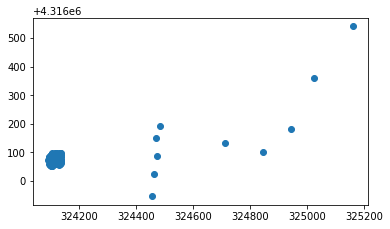

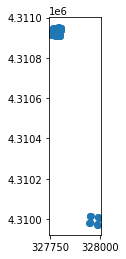

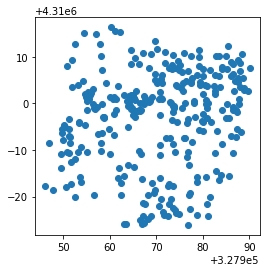

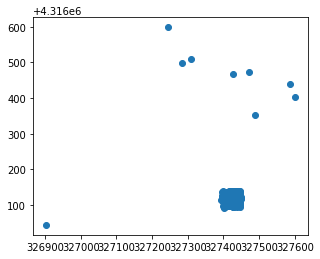

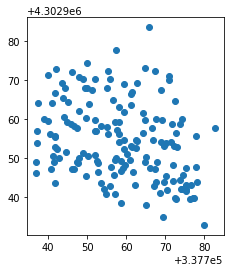

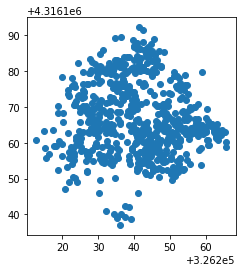

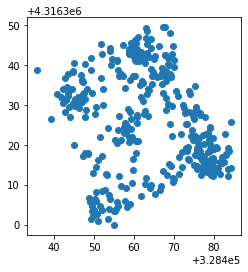

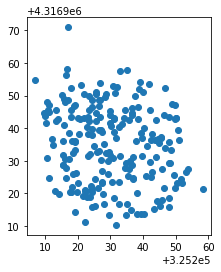

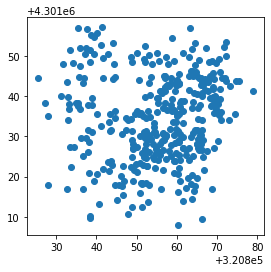

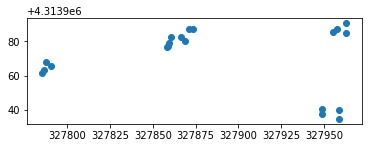

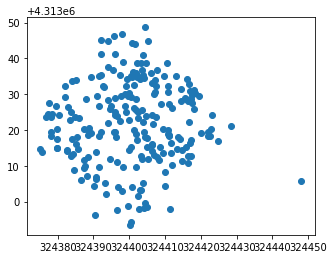

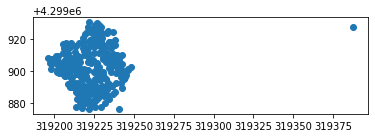

In [21]:
# plot to check they're functional
for gpdf in appd_gpdf:
    gpdf.plot()

### Interact

In [23]:
# print ordered list of new geodataframes
print([i for i in appd_files if i.endswith('.shp')])

['Schofield-23.shp', 'Snodgrass-2.shp', 'Snodgrass-1.shp', 'Schofield-19.shp', 'PointLookout-1.shp', 'Schofield-24.shp', 'Schofield-5.shp', 'Schofield-4.shp', 'SplainsGulch-1.shp', 'ResearchMeadow.shp', 'Wash-1.shp', 'OhioPass-1.shp']


In [25]:
#print(appd_gpdf[0].loc[:, 'Other'])

# function to interact with dataframe
def fh_interact(df):
    '''
    outputs sliders that show rows and cols of df
    '''
    def peek(row = 1, col = 0):
        return df.iloc[row: row+10, col: col+10]
    interact(peek, row = (0, len(df), 5), col = (0, len(df.columns) - 6))
    print('({} rows, {} columns total'.format(df.shape[0], df.shape[1]))

### Clean Schofield-23 (as appd_gpdf[0])

In [26]:
fh_interact(appd_gpdf[0])

interactive(children=(IntSlider(value=1, description='row', max=211, step=5), IntSlider(value=0, description='…

(211 rows, 30 columns total


In [368]:
# slice out any non-tree points by removing entries where 'Comment' != 'None'
appd_gpdf[0]['Comment'] = [str(i) for i in appd_gpdf[0]['Comment']]
appd_gpdf[0] = appd_gpdf[0].loc[appd_gpdf[0]['Comment'] == 'None']

# create 'sp_code' field and populate with species code from 'Other' field
#appd_gpdf[0]['Comment'].dtype
appd_gpdf[0]['GPS_Sp_Code'] = [str(i).upper()[:4] for i in appd_gpdf[0]['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
appd_gpdf[0]['GPS_Tag_Number'] = [int(str(i)[:4]) for i in appd_gpdf[0]['Other2']]

# create 'GPS_Geotag_Association_Ref'
appd_gpdf[0]['GPS_Geotag_Association'] = [str(i).upper()[5:].strip('- ') for i in appd_gpdf[0]['Other']]


In [369]:
print('data type: ' + str(appd_gpdf[0]['GPS_Geotag_Association'].dtype))
print(appd_gpdf[0]['GPS_Geotag_Association'].unique())

data type: object
['' '6233 50CM SW' '6227 50CM SE' '6287 10CM SE' '6240 10CM SW'
 '6246 40CM W' '1387 SAME BASE' '1383 SAME BASE' '\\' 'TOUCHING 6252'
 '1371 SAME BASE' '1376 SAME BASE' 'FELL NE PREVIOUSLY W/ 1336'
 'FELL EAST' '1277 SAME BASE' '6272 40CM SOUTH' '6230 30CM EAST'
 '6263 SAME BASE']


<AxesSubplot:>

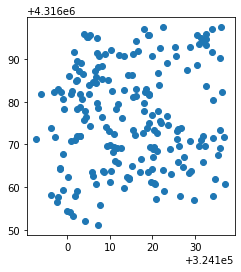

In [333]:
# plot to check
appd_gpdf[0].plot()

## Clean Snod-2 as appd_gpdf[1]

In [50]:
fh_interact(appd_gpdf[1])

interactive(children=(IntSlider(value=1, description='row', max=434, step=5), IntSlider(value=0, description='…

(434 rows, 32 columns total


In [32]:
# slice out any non-tree points by removing entries where 'Comment' != 'None'
appd_gpdf[1]['Comment'] = [str(i) for i in appd_gpdf[1]['Comment']]
appd_gpdf[1] = appd_gpdf[1].loc[appd_gpdf[1]['Comment'] == 'None']

array(['None'], dtype=object)

In [37]:
# create 'sp_code' field and populate with species code from 'Other' field
appd_gpdf[1]['GPS_Sp_Code'] = [str(i).upper()[:4] for i in appd_gpdf[1]['Other']]
appd_gpdf[1]['GPS_Sp_Code'].unique()

array(['PIEN', 'ABLA', 'PICO', 'UNKN', 'UNK4', '49 .', '5853', 'LABL'],
      dtype=object)

In [51]:
# create 'Tag_Number' as first four elements in each 'Other2' entry
appd_gpdf[1]['GPS_Tag_Number'] = [str(i)[:4] for i in appd_gpdf[1]['Other2']]

# slice out any trees with 'nt' tags
appd_gpdf[1] = appd_gpdf[1].loc[~appd_gpdf[1]['GPS_Tag_Number'].str.contains('nt', na = False)]

array(['5781', '5782', '6036', '5789', '5788', '5780', '5784', '5787',
       '5797', '6043', '5786', '5770', '5769', 'None', '5800', '5768',
       '5767', '5747', '5738', '5739', '5740', '5766', '5765', '5764',
       '5749', '5714', '5752', '5751', '5750', '3314', '3315', '3316',
       '3318', '3317', '3319', '3320', '3321', '3322', '3323', '3324',
       '3326', '3327', '3329', '3332', '3334', '3337', '3335', '3338',
       '3339', '3340', '3341', '3343', '3344', '3346', '3355', '3356',
       '3357', '3358', '3351', '3349', '3348', '3347', '3353', '3359',
       '3360', '3363', '3364', '3367', '3369', '3368', '3372', '3371',
       '3373', '3374', '3375', '3377', '3378', '3379', '3380', '5718',
       '6011', '5719', '5721', '5720', '6012', '5724', '5725', '5726',
       '5727', '6013', '5730', '5731', '6014', '5729', '5754', '6021',
       '6020', '6022', '6023', '6024', '6026', '6027', '5762', '6029',
       '6028', '5849', '5763', '6030', '5839', '6031', '5799', '5840',
      

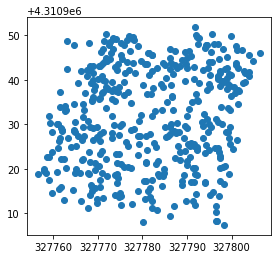

In [53]:
# plot to check
appd_gpdf[1].plot()
appd_gpdf[1].to_file(directory + '/Snod2_clean.shp')

## Scratch

In [334]:
# scratch
#alltrees_gpdf
#[i.shape for i in alltrees_gpdf]
#[i['Site'] for i in alltrees_gpdf]
#[i['geometry'] for i in alltrees_gpdf]

In [335]:
# scratch
trees_sf_grouped = [[value for value in trees_sf if key in value] for key in set(sitelist)]
trees_sf_grouped = [i for i in trees_sf_grouped if len(i) != 0]
trees_sf_grouped

# alltrees_gpdf = []
# for thing in trees_sf_grouped:
#     for i in thing:
#         longpath = renamed_dir + os.sep + i
#         alltrees_gpdf.append(longpath)

# for file_name in snod2_paths:
#     snod2_sf = gpd.read_file(file_name)
#     wdpa = wdpa[['ISO3', 'geometry', 'PA_DEF', 'STATUS_YR']]
#     wdpa_dissolve = wdpa.dissolve(by='PA_DEF', aggfunc='max')

#     new_file_name = file_name[:6] + "_dissolve.shp" # wdpa95_dissolve.shp
#     # OR 
#     # new_file_name = file_name[:-4] + "_dissolve.shp" # wdpa95_uk_terr_dissolve.shp

#     new_file_path = os.path.join(shp_folder, new_file_name)
#     wdpa_dissolve.to_file(new_file_path)

[['WORSHAMM071811A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM081408A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM072008A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM072107A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM081414A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM073112A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM071610A_Snodgrass-2_Point_ge_Project.shp',
  'WORSHAMM072010A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM081109A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM072007A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM071710C_Snodgrass-2_Student_Project.shp',
  'WORSHAMM071810A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM071808A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM071810B_Snodgrass-2_Student_Project.shp',
  'WORSHAMM081108A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM081411A_Snodgrass-2_Student_Project.shp',
  'WORSHAMM081415A_Snodgrass-2_Student_Project.shp'],
 ['WORSHAMM080912A_Schofield-5_Student2_Project.shp',
  'WORSHAMM080713A_Schofield-5_Student_Proj

In [336]:
# scratch for one shapefile
snod2 = 'Snodgrass-2'
snod2_trees = [t for t in trees_sf if (snod2 in t and t.endswith('.shp'))]
#snod2_trees[:10]

# import one shapefile as geopandas dataframe
snod2_trees0 = gpd.read_file(renamed_dir + os.sep + snod2_trees[0])
snod2_trees0.head(5)
snod2_trees[0]

#res = [ele for ele in test_list if(ele in test_string)]

snod2_site = [i for i in sitelist if i in snod2_trees[0]][0]
snod2_trees0['Site'] = snod2_site

snod2_trees0.to_crs(epsg=32613, inplace = True)
snod2_trees0.crs
snod2_trees0.geom_type.unique()

# plot geodataframe
# snod2_trees0.plot()

array(['Point'], dtype=object)